# Стохастический градиентный и координатный спуски

Для каждого задания указано количество баллов (если они оцениваются отдельно) + 1 балл за аккуратное и полное выполнение всего задания

In [194]:
import numpy as np
import pandas as pd
from sklearn import metrics # инструменты для оценки точности модели  

## Загрузка и подготовка данных

**Загрузите уже знакомый вам файл *Advertising.csv* как объект DataFrame.** 

In [195]:
df = pd.read_csv('data/Advertising.csv',index_col=0)

**Проверьте, есть ли в данных пропуски и, если они есть - удалите их**

In [196]:
df.info() # ни одного пропуска

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


**Преобразуйте ваши признаки в массивы NumPy и разделите их на переменные X (предикторы) и y (целевая переменная)** 

In [197]:
X_original = df.drop(['sales'], axis = 1)
y = df['sales']
n = len(y)
X_original = X_original.values.reshape(n,3)
y = df['sales'].values.reshape(n,1)

## Координатный спуск (3 балла)

**Добавим единичный столбец для того, чтобы у нас был свободный коэффициент в уравнении регрессии:**

In [198]:
X = np.hstack([np.ones(X_original.shape[0]).reshape(-1, 1), X_original])

**Нормализуем данные: обычно это необходимо для корректной работы алгоритма**

In [199]:
X = X / np.sqrt(np.sum(np.square(X), axis=0))

**Реализуйте алгоритм координатного спуска:** (3 балла)

Ниже приведен алгоритм:

<a href="https://ibb.co/Th3BQFn"><img src="https://i.ibb.co/DK2DBS6/zascas.jpg" alt="zascas" border="0"></a>

Примечание: 1000 итераций здесь указаны для этого задания, на самом деле их может быть намного больше, нет детерменированного значения.

Вам необходимо реализовать координатный спуск, и вывести веса в модели линейной регрессии.

In [268]:
def costs(y_true, y_predicted):
    return np.sum(np.square(y_true - y_predicted)) / y_true.shape[0]

# выберем начальной точкой - точку отсчёта
w_init = np.zeros((4, 1))
# а шагом - единичный шаг
step = np.ones((4, 1))
while True:
    for j, w in enumerate(w_init):
        w_next = np.copy(w_init)
        costs_current = costs(y, X @ w_init)
        # оценим значения функции ошибки левее и правее точки соответственно:
        # 1) левее
        left = w - step[j]
        w_next[j] = left
        costs_left = costs(y, X @ w_next)
        # 2) правее
        right = w + step[j]
        w_next[j] = right
        costs_right = costs(y, X @ w_next)
        # нам необходимо двигаться в сторону уменьшения функции ошибки
        if costs_left < costs_right and costs_left < costs_current:
            w_init[j] = left
            costs_next = costs_left
        elif costs_right < costs_left and costs_right < costs_current:
            w_init[j] = right
            costs_next = costs_right
        # проскочили минимум и шаг надо уменьшать
        elif costs_right > costs_left > costs_current:
            w_init[j] = left
            costs_next = costs_left
            step[j] = step[j] / 2
        elif costs_left > costs_right > costs_current:
            w_init[j] = right
            costs_next = costs_right
            step[j] = step[j] / 2
    # критерием останова пусть будет точность в 10 знаков после запятой
    # для нашей функции ошибки
    if abs(costs_next - costs_current) < 10**-10: break

y_pred = X @ w_init
print(f'\033[1mMAPE для алгоритма коорд. спуска:\033[0m\n\
    {metrics.mean_absolute_percentage_error(y, y_pred)*100:.5f}%\n')
print(f'\033[1mВеса модели коорд. спуска:\033[0m\n{w_init}')

MAPE для алгоритма коорд. спуска:
    13.87787%

Веса модели коорд. спуска:
[[14.0225]
 [ 3.9193]
 [ 2.7921]
 [-0.0225]]


Сравните результаты с реализацией линейной регрессии из библиотеки sklearn:

In [269]:
from sklearn.linear_model import LinearRegression
 
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = model.predict(X)
print(f'\033[1mMAPE для алгоритма линейной регрессии:\033[0m\n\
    {metrics.mean_absolute_percentage_error(y, y_pred)*100:.5f}%\n')
print(f'\033[1mВеса модели линейной регрессии:\033[0m\n{model.coef_}')

MAPE для алгоритма линейной регрессии:
    13.87785%

Веса модели линейной регрессии:
[[14.0225  3.9193  2.7921 -0.0225]]


Если вы все сделали верно, они должны практически совпасть!

## Стохастический градиентный спуск (6 баллов)

**Отмасштабируйте столбцы исходной матрицы *X* (которую мы не нормализовали еще!). Для того, чтобы это сделать, надо вычесть из каждого значения среднее и разделить на стандартное отклонение** (0.5 баллов)

In [202]:
X = (X_original - np.mean(X_original, axis=0)) / np.std(X_original, axis=0)

**Добавим единичный столбец**

In [203]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

**Создайте функцию mse_error для вычисления среднеквадратичной ошибки, принимающую два аргумента: реальные значения и предсказывающие, и возвращающую значение mse** (0.5 балла)

In [290]:
def mse_error(y_real,y_pred,round=10):
    mse = (np.square(y_real - y_pred)).mean()
    return mse.round(round)

**Сделайте наивный прогноз: предскажите продажи средним значением. После этого рассчитайте среднеквадратичную ошибку для этого прогноза** (0.5 балла)

In [205]:
y_pred = np.full((y.shape[0],y.shape[1]),y.mean())

mse_error(y,y_pred)

27.08574375

**Создайте функцию *lin_pred*, которая может по матрице предикторов *X* и вектору весов линейной модели *w* получить вектор прогнозов** (0.5 балла)

In [277]:
def lin_pred(x,w):
    y_pred = np.dot(X,w)
    return y_pred

**Создайте функцию *stoch_grad_step* для реализации шага стохастического градиентного спуска. (1.5 балла) 
Функция должна принимать на вход следующие аргументы:**
* матрицу *X*
* вектора *y* и *w*
* число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов
* число *$\eta$* (eta) - шаг градиентного спуска

Результатом будет вектор обновленных весов

Шаг для стохастического градиентного спуска выглядит следующим образом:

$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$

Для того, чтобы написать функцию, нужно сделать следующее:
    
*  посчитать направление изменения: умножить объект обучающей выборки на 2 и на разницу между предсказанным значением и реальным, а потом поделить на количество элементов в выборке.
* вернуть разницу между вектором весов и направлением изменения, умноженным на шаг градиентного спуска

In [272]:
def stoch_grad_step(x, y, w, train_ind, eta=1.0):
    temp = 2 * x[train_ind, :] * (np.dot(x[train_ind, :],w) - y[train_ind])/ x.shape[0]
    return w - eta * temp.reshape(-1, 1)

**Создайте функцию *stochastic_gradient_descent*, для реализации стохастического градиентного спуска (2.5 балла)**

**Функция принимает на вход следующие аргументы:**
- Матрицу признаков X
- Целевую переменнную
- Изначальную точку (веса модели)
- Параметр, определяющий темп обучения
- Максимальное число итераций
- Евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,при котором алгоритм прекращает работу 

**На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.**

Алгоритм сследующий:
    
* Инициализируйте расстояние между векторами весов на соседних итерациях большим числом (можно бесконечностью)
* Создайте пустой список для фиксации ошибок
* Создайте счетчик итераций
* Реализуйте оновной цикл обучения пока расстояние между векторами весов больше того, при котором надо прекратить работу (когда расстояния станут слишком маленькими - значит, мы застряли в одном месте) и количество итераций меньше максимально разрешенного: сгенерируйте случайный индекс, запишите текущую ошибку в вектор ошибок, запишите в переменную текущий шаг стохастического спуска с использованием функции, написанной ранее. Далее рассчитайте текущее расстояние между векторами весов и прибавьте к счетчику итераций 1.
* Верните вектор весов и вектор ошибок

In [291]:
def stochastic_gradient_descent(x, y, w, stop_criterion, iter_max, eta=1.0):
    mse_list = []  # пустой список для фиксации ошибок
    np.random.seed(42)
    i = 0  # счетчик итераций
    while i < iter_max:
        idx = np.random.randint(x.shape[0])  # сгенерируйте случайный индекс
        # запишите текущую ошибку в вектор ошибок
        mse_list.append(mse_error(y, lin_pred(x, w)))
        # запишите в переменную текущий шаг стохастического спуска с
        # использованием функции, написанной ранее
        theta = stoch_grad_step(x, y, w, idx, eta)
        # если длина шага меньше желаемой точности завершаем цикл
        if np.linalg.norm(theta - w) < stop_criterion: break
        w = theta  # обновляем веса
        i += 1
    return w, mse_list

 **Запустите $10^5$ итераций стохастического градиентного спуска. Укажите вектор начальных весов, состоящий из нулей. Можете поэкспериментировать с параметром, отвечающим за темп обучения.**

In [292]:
w = np.zeros((4, 1))
w_stoch, mse_list = stochastic_gradient_descent(X,y,w,0.0002,100000)

**Постройте график зависимости ошибки от номера итерации**

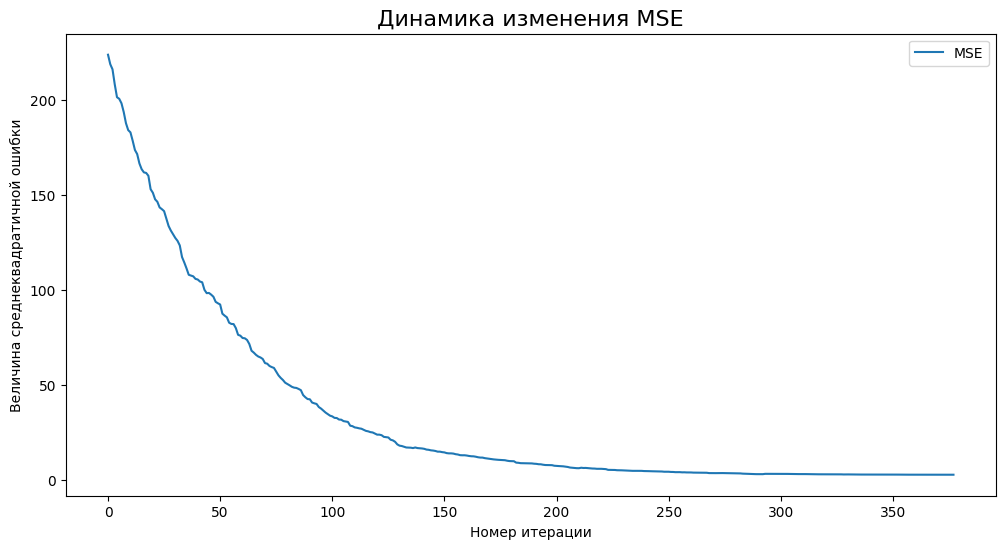

In [293]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 6))
lineplot = sns.lineplot(data=pd.DataFrame(mse_list, columns=['MSE']))
lineplot.set_title('Динамика изменения MSE', fontsize=16)
lineplot.set_xlabel('Номер итерации')
lineplot.set_ylabel('Величина среднеквадратичной ошибки');

**Выведите вектор весов, к которому сошелся метод.**

In [294]:
np.set_printoptions(precision=4,suppress=True)
w_stoch

array([[13.9037],
       [ 4.0301],
       [ 2.6162],
       [ 0.0147]])

**Выведите среднеквадратичную ошибку на последней итерации.**

In [295]:
mse_list[-1]

2.8365340152